In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, RobustScaler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from category_encoders import CatBoostEncoder
from yellowbrick.classifier import ROCAUC
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
random.seed(2814)

In [2]:
# Read in Imputed dataset
df = pd.read_csv('../data/processed/Define/seai_missingforest_data_imputed.csv')

In [3]:
# Feature Engineering
conditions = [
    (df['MainSpaceHeatingFuel'] == 'Heating Oil'),
    (df['MainSpaceHeatingFuel'] == 'Electricity') 
    ]

# create a list of the values we want to assign for each condition
values = [28.23, 7.93]

# create a new column and use np.select to assign values to it using our lists as arguments
df['EnergyCost'] = np.select(conditions, values, 7.93)
df['EnergyCost'] = (df['TotalDeliveredEnergy'] * df['EnergyCost']) / 100
# display updated DataFrame
df.head()

,CountyName,DwellingTypeDescr,YearofConstruction,GroundFloorArea(sq m),MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,EnergyRating,EnergyCost
0,Donegal,Detached house,1997,171.19,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,20.00,25474.522,C2,7191.457561
1,Kildare,Detached house,2010,242.93,Heating Oil,Heating Oil,Natural vent.,Masonry,two,Factory Insulated,50.00,27654.474,B3,7806.858010
2,Dublin,Semi-detached house,1999,99.38,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Loose Jacket,20.00,17000.038,C3,1348.103013
3,Dublin,Semi-detached house,1965,138.41,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Factory Insulated,39.35,22708.484,C2,1800.782781
4,Dublin,Semi-detached house,1985,127.16,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Loose Jacket,100.00,28182.863,D2,2234.901036


In [4]:
# Move BER to the very end 
new_cols = [col for col in df.columns if col != 'EnergyRating'] + ['EnergyRating']
df = df[new_cols]
del(new_cols)

In [5]:
# Make sure year is not counted as a numerical feature
df['YearofConstruction'] = df['YearofConstruction'].astype('object')

##### Outline of steps for data to go through in a pipe:

- Data Ingestion
- Data Cleaning
- Data Imputation
- Data Sampling
- Data Splitting of Categorical and Numerical pipes within main pipe
- Run MinMaxScaler on Numerical data
- Run OneHotEncoding on the 

Now that impute is complete, we need to sample the dataset

In [6]:
# Separate feature and target variables
X = df.iloc[:, :-1] # Independent Variables
y = df.iloc[:, -1] # Dependent Variables

In [7]:
# Randomly distribute the data so CatBoost can work
perm = np.random.permutation(len(X))
X = X.iloc[perm].reset_index(drop=True) 
y = y.iloc[perm].reset_index(drop=True)

In [8]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=2814)

In [9]:
# Label Encoding of Target for CatBoost
yle = LabelEncoder()
y_train = yle.fit_transform(y_train)
y_test = yle.transform(y_test)

In [10]:
# CatBoost Encoding
cbe_encoder = ce.cat_boost.CatBoostEncoder()
X_train = cbe_encoder.fit_transform(X_train, y_train)
X_test = cbe_encoder.transform(X_test)

In [11]:
# Taking a look at the encoding
pd.DataFrame(X_train)

,CountyName,DwellingTypeDescr,YearofConstruction,GroundFloorArea(sq m),MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,EnergyCost
210580,8.129275,8.129275,8.129275,93.84,8.129275,8.129275,8.129275,8.129275,8.129275,8.129275,35.0,12752.764150,1011.294197
579533,8.129275,8.129275,8.129275,241.36,8.129275,8.129275,9.064637,9.064637,9.064637,9.064637,31.2,42053.979200,11871.838328
322228,8.129275,8.129275,8.129275,79.14,9.064637,9.064637,8.709758,8.129275,8.709758,8.709758,50.0,15655.508000,1241.481784
128628,9.064637,10.064637,8.129275,153.80,8.129275,8.129275,9.532319,8.709758,8.129275,9.532319,25.0,28096.960870,2228.088997
755892,8.129275,8.064637,8.129275,100.49,8.129275,8.129275,9.225855,8.532319,9.532319,8.129275,80.0,55217.851000,4378.775584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846309,8.020595,8.415057,7.232520,70.63,7.964817,8.158532,8.404363,8.251403,8.476659,7.390521,24.0,11057.941529,876.894763
725523,7.935856,8.159020,11.562377,73.06,8.481389,8.468606,8.404366,8.251407,8.062357,7.390528,31.7,26340.163410,7435.828131
466912,8.492679,8.159041,6.594210,157.52,8.481405,8.468622,8.404373,8.251414,8.076472,7.390540,35.0,17516.926000,4945.028210
211647,7.935915,8.004764,11.238552,77.00,7.430201,7.413606,8.404368,8.251409,8.076457,8.440390,0.0,20458.542550,1622.362424


In [12]:
# Scaling the dataset. Not required for tree models but good practice.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [13]:
# Use value counts as reference for under sampler
pd.DataFrame(y_train).value_counts().sort_index()

0       785
1     20778
2     27427
3     11093
4     24924
5     60160
6     88307
7     97297
8     92860
9     90079
10    77538
11    44791
12    35494
13    36765
14    53158
dtype: int64

In [14]:
resample=SMOTETomek(random_state=2814)
X_train, y_train = resample.fit_resample(X_train, y_train)

In [18]:
model = RandomForestClassifier(random_state=2814, criterion='entropy')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.44      0.42       196
           1       0.90      0.88      0.89      5195
           2       0.87      0.88      0.88      6857
           3       0.66      0.74      0.70      2773
           4       0.76      0.78      0.77      6231
           5       0.83      0.84      0.83     15040
           6       0.84      0.82      0.83     22077
           7       0.83      0.80      0.82     24325
           8       0.81      0.78      0.79     23215
           9       0.80      0.77      0.78     22520
          10       0.79      0.79      0.79     19384
          11       0.69      0.76      0.72     11198
          12       0.72      0.77      0.74      8873
          13       0.76      0.84      0.80      9191
          14       0.94      0.92      0.93     13290

    accuracy                           0.81    190365
   macro avg       0.77      0.79      0.78    190365
weighted avg       0.81   

In [20]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.43877551, 0.88046198, 0.87866414, 0.73566534, 0.78189697,
       0.84128989, 0.82284731, 0.80073998, 0.77531768, 0.77122558,
       0.78606067, 0.7579925 , 0.77335738, 0.83527364, 0.92475546])

In [31]:
from numpy import save
save('../data/interim/Design/X_train.npy', X_train)
save('../data/interim/Design/X_test.npy', X_test)
save('../data/interim/Design/y_train.npy', y_train)
save('../data/interim/Design/y_test.npy', y_test)

In [17]:
# Save our final model
import pickle
filename = '../models/final_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [18]:
# Test model import
filename = '../models/final_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8087043311533108


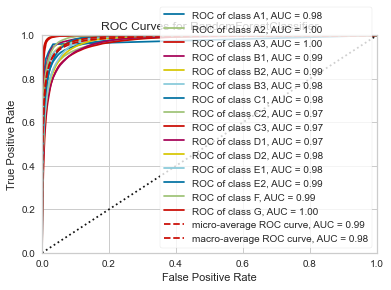

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1',
                'D2', 'E1', 'E2', 'F', 'G'],
       estimator=RandomForestClassifier(criterion='entropy', random_state=2814))

In [28]:
# Develop ROC curve for multi classification
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['A1','A2','A3','B1','B2','B3','C1','C2','C3','D1','D2','E1','E2','F','G'])    

---
---

Testing other models 

In [30]:
# Modelling
dt = DecisionTreeClassifier(random_state=2814, criterion='entropy', min_samples_split=5)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.45      0.33       196
           1       0.84      0.85      0.84      5195
           2       0.84      0.82      0.83      6857
           3       0.50      0.69      0.58      2773
           4       0.61      0.71      0.65      6231
           5       0.75      0.76      0.75     15040
           6       0.77      0.75      0.76     22077
           7       0.76      0.73      0.74     24325
           8       0.72      0.71      0.71     23215
           9       0.73      0.71      0.72     22520
          10       0.74      0.71      0.72     19384
          11       0.64      0.69      0.66     11198
          12       0.66      0.71      0.68      8873
          13       0.75      0.77      0.76      9191
          14       0.93      0.91      0.92     13290

    accuracy                           0.74    190365
   macro avg       0.70      0.73      0.71    190365
weighted avg       0.75   

In [21]:
lr = LogisticRegression(random_state=2814, solver='sag')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.47      0.05       196
           1       0.62      0.58      0.60      5195
           2       0.60      0.48      0.53      6857
           3       0.09      0.30      0.14      2773
           4       0.11      0.36      0.17      6231
           5       0.15      0.30      0.20     15040
           6       0.16      0.07      0.10     22077
           7       0.29      0.06      0.10     24325
           8       0.26      0.11      0.15     23215
           9       0.23      0.13      0.16     22520
          10       0.20      0.14      0.16     19384
          11       0.10      0.19      0.13     11198
          12       0.11      0.16      0.13      8873
          13       0.20      0.31      0.24      9191
          14       0.50      0.75      0.60     13290

    accuracy                           0.22    190365
   macro avg       0.24      0.29      0.23    190365
weighted avg       0.25   

In [22]:
svm = LinearSVC(random_state=2814)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.50      0.04       196
           1       0.51      0.63      0.56      5195
           2       0.25      0.37      0.30      6857
           3       0.04      0.26      0.07      2773
           4       0.08      0.48      0.14      6231
           5       0.11      0.17      0.14     15040
           6       0.04      0.00      0.00     22077
           7       0.21      0.00      0.00     24325
           8       0.34      0.00      0.00     23215
           9       0.01      0.00      0.00     22520
          10       0.04      0.02      0.02     19384
          11       0.07      0.10      0.08     11198
          12       0.08      0.12      0.09      8873
          13       0.10      0.25      0.14      9191
          14       0.40      0.89      0.56     13290

    accuracy                           0.15    190365
   macro avg       0.15      0.25      0.14    190365
weighted avg       0.15   

In [23]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.79      0.04       196
           1       0.45      0.45      0.45      5195
           2       0.35      0.35      0.35      6857
           3       0.09      0.14      0.11      2773
           4       0.12      0.21      0.15      6231
           5       0.31      0.15      0.20     15040
           6       0.22      0.36      0.27     22077
           7       0.23      0.08      0.11     24325
           8       0.23      0.05      0.08     23215
           9       0.21      0.38      0.27     22520
          10       0.21      0.16      0.18     19384
          11       0.07      0.00      0.00     11198
          12       0.05      0.00      0.00      8873
          13       0.16      0.51      0.24      9191
          14       0.51      0.60      0.55     13290

    accuracy                           0.23    190365
   macro avg       0.22      0.28      0.20    190365
weighted avg       0.23   

In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.35      0.18       196
           1       0.73      0.76      0.74      5195
           2       0.69      0.69      0.69      6857
           3       0.20      0.42      0.27      2773
           4       0.21      0.42      0.28      6231
           5       0.26      0.36      0.30     15040
           6       0.31      0.28      0.29     22077
           7       0.31      0.22      0.25     24325
           8       0.29      0.22      0.25     23215
           9       0.30      0.22      0.25     22520
          10       0.28      0.24      0.26     19384
          11       0.19      0.26      0.22     11198
          12       0.18      0.26      0.21      8873
          13       0.25      0.30      0.27      9191
          14       0.70      0.59      0.64     13290

    accuracy                           0.31    190365
   macro avg       0.33      0.37      0.34    190365
weighted avg       0.33   

In [25]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.74      0.05       196
           1       0.35      0.13      0.19      5195
           2       0.58      0.46      0.51      6857
           3       0.07      0.23      0.11      2773
           4       0.15      0.15      0.15      6231
           5       0.20      0.22      0.21     15040
           6       0.26      0.36      0.30     22077
           7       0.31      0.13      0.18     24325
           8       0.25      0.28      0.27     23215
           9       0.25      0.26      0.25     22520
          10       0.20      0.17      0.18     19384
          11       0.14      0.16      0.15     11198
          12       0.14      0.10      0.12      8873
          13       0.18      0.24      0.20      9191
          14       0.68      0.37      0.48     13290

    accuracy                           0.24    190365
   macro avg       0.25      0.27      0.22    190365
weighted avg       0.27   

In [26]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train)
y_pred = hgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.69      0.26       196
           1       0.86      0.82      0.84      5195
           2       0.86      0.80      0.83      6857
           3       0.56      0.70      0.62      2773
           4       0.68      0.75      0.71      6231
           5       0.78      0.80      0.79     15040
           6       0.81      0.78      0.80     22077
           7       0.81      0.76      0.78     24325
           8       0.78      0.74      0.76     23215
           9       0.78      0.74      0.76     22520
          10       0.76      0.74      0.75     19384
          11       0.65      0.74      0.69     11198
          12       0.66      0.76      0.71      8873
          13       0.73      0.82      0.77      9191
          14       0.94      0.90      0.92     13290

    accuracy                           0.77    190365
   macro avg       0.72      0.77      0.73    190365
weighted avg       0.78   

In [27]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=2814)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.62      0.34       196
           1       0.88      0.86      0.87      5195
           2       0.87      0.84      0.85      6857
           3       0.66      0.71      0.68      2773
           4       0.73      0.76      0.75      6231
           5       0.81      0.83      0.82     15040
           6       0.83      0.82      0.82     22077
           7       0.83      0.78      0.80     24325
           8       0.79      0.77      0.78     23215
           9       0.80      0.75      0.77     22520
          10       0.78      0.76      0.77     19384
          11       0.68      0.76      0.72     11198
          12       0.69      0.78      0.73      8873
          13       0.77      0.83      0.80      9191
          14       0.95      0.93      0.94     13290

    accuracy                           0.80    190365
   macro avg       0.75      0.79      0.76    190365
weighted avg       0.80   